# Generating Digits with a Diffusion Model

<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<a href="https://colab.research.google.com/github/noctonic/DeepLearningCrashCourse/blob/main/Ch10_Diffusion/ec10_1_ddpm_mnist/ddpm_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<strong>If using Colab/Kaggle:</strong> You need to uncomment the code in the cell below this one.
</div>

In [1]:
!pip install deeplay  # Uncomment if using Colab/Kaggle.

This notebook provides you with a complete code example to generate MNIST digits with a diffusion model.

<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<strong>Note:</strong> This notebook contains the Code Example 10-1 from the book  

**Deep Learning Crash Course**  
Giovanni Volpe, Benjamin Midtvedt, Jesús Pineda, Henrik Klein Moberg, Harshith Bachimanchi, Joana B. Pereira, Carlo Manzo  
No Starch Press, San Francisco (CA), 2026  
ISBN-13: 9781718503922  

[https://nostarch.com/deep-learning-crash-course](https://nostarch.com/deep-learning-crash-course)

You can find the other notebooks on the [Deep Learning Crash Course GitHub page](https://github.com/noctonic/DeepLearningCrashCourse).
</div>

## Loading the MNIST Dataset with PyTorch

Implement the normalization of the digits ...

In [2]:
from torchvision.transforms import Compose, Normalize, ToTensor

trans = Compose([ToTensor(), Normalize(mean=[0.5], std=[0.5], inplace=True)])

... import the MNIST digits ...

In [3]:
from torchvision.datasets import MNIST

trainset = MNIST(root="data", train=True, transform=trans, download=True)

... and plot some of the transformed MNIST digits.

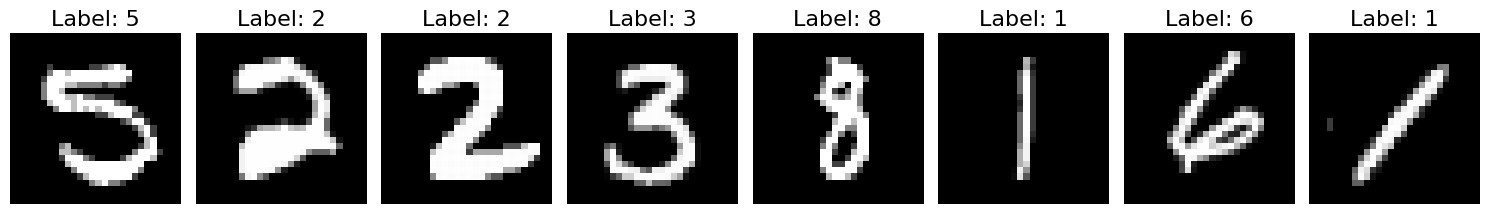

In [4]:
import torch
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 8, figsize=(15, 3))
for ax in axs.ravel():
    img, label = trainset[torch.randint(0, len(trainset), (1,)).squeeze()]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(f"Label: {label}", fontsize=16)
    ax.axis("off")
plt.tight_layout()
plt.show()

## Implementing the Forward Process

Define the device on which the computations are performed ...

In [ ]:
def get_device():
    """Select device where to perform the computations."""
    if torch.cuda.is_available():
        return torch.device("cuda:0")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_device()

print(f"Selected device: {device}")

Selected device: cpu


... implement the forward diffusion process ...

In [6]:
class Diffusion:
    """Denoising diffusion probabilistic model (DDPM)."""

    def __init__(self, steps=1000, beta_start=1e-4, beta_end=0.02,
                 device=device):
        """Initialize the diffusion model."""
        self.steps, self.device = steps, device
        self.beta = torch.linspace(beta_start, beta_end, steps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def forward_diffusion(self, x, t):
        """Implement the forward diffusion process."""
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = \
            torch.sqrt(1 - self.alpha_bar[t])[:, None, None, None]
        noise = torch.randn_like(x)
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise, noise

... sampling images in the forward diffusion process ..

In [7]:
diffusion = Diffusion(steps=401, beta_start=0.0001, beta_end=0.02)

clean_image, label = trainset[torch.randint(0, len(trainset), (1,)).squeeze()]

steps, noisy_images = [0, 100, 200, 300, 400], []
for t in steps:
    noisy_image, noise = diffusion.forward_diffusion(
        x=clean_image[None, ...].to(device), t=torch.tensor([t]).to(device),
    )
    noisy_images.append(noisy_image)

... and visualize the noisy digits generated in the forward diffusion process.

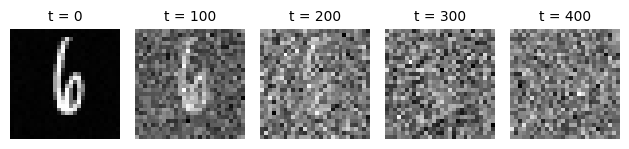

In [8]:
fig, axs = plt.subplots(1, len(steps))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(noisy_images[i].cpu().numpy().squeeze(), cmap="gray")
    ax.set_title(f"t = {steps[i]}", fontsize=10)
    ax.axis("off")
plt.tight_layout()
plt.show()

## Implementing the Reverse Diffusion Process

Update the `Diffusion` class to implement the reverse diffusion process.

In [ ]:
from tqdm import tqdm

class Diffusion:
    """Denoising diffusion probabilistic model (DDPM)."""

    def __init__(self, steps=1000, beta_start=1e-4, beta_end=0.02, img_size=28,
                 device=device):
        """Initialize the diffusion model."""
        self.steps, self.img_size, self.device = steps, img_size, device
        self.beta = torch.linspace(beta_start, beta_end, steps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def forward_diffusion(self, x, t):
        """Implement the forward diffusion process."""
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = \
            torch.sqrt(1 - self.alpha_bar[t])[:, None, None, None]
        noise = torch.randn_like(x)
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise, noise

    def reverse_diffusion(self, model, n_images, n_channels, pos_enc_dim,
                          pos_enc_func, fix_noise=None, save_time_steps=None):
        """Reverse diffusion process."""
        with torch.no_grad():
            if fix_noise is not None:
                x = fix_noise.to(self.device)
            else:
                x = torch.randn(
                    (n_images, n_channels, self.img_size, self.img_size),
                ).to(self.device)

            denoised_images = []
            for i in tqdm(reversed(range(0, self.steps)),
                        desc="U-Net inference", total=self.steps):
                t = (torch.ones(n_images) * i).long()
                t_pos_enc = (pos_enc_func(t.unsqueeze(1), pos_enc_dim)
                            .to(self.device))
                pred_noise = model(x=x, t=t_pos_enc)
                alpha = self.alpha[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                noise = torch.randn_like(x) if i > 0 else torch.zeros_like(x)
                x = (1 / torch.sqrt(alpha) 
                    * (x - ((1 - alpha) / torch.sqrt(1 - alpha_bar))
                       * pred_noise)
                    + torch.sqrt(1 - alpha) * noise)
                if i in save_time_steps: denoised_images.append(x)

            denoised_images = torch.stack(denoised_images).swapaxes(0, 1)
            return denoised_images

## Defining the Position Encoding Function

Implement the position encoding function ...

In [10]:
def positional_encoding(t, enc_dim):
    """Encode position information with a sinusoid."""
    scaled_positions = torch.arange(0, enc_dim, 2).float() / enc_dim
    frequency = 10_000 ** scaled_positions
    inverse_frequency = (1.0 / frequency).to(t.device)
    angle = t.repeat(1, enc_dim // 2) * inverse_frequency
    pos_enc_sin, pos_enc_cos = torch.sin(angle), torch.cos(angle)
    pos_enc = torch.cat([pos_enc_sin, pos_enc_cos], dim=-1)
    return pos_enc

... sinusoidal position encodings for different time steps ...

In [11]:
pos_enc_dim = 256

pos_encs = []
for i in range(0, 100):
    t = torch.tensor([i])
    pos_enc = positional_encoding(t, pos_enc_dim)
    pos_encs.append(pos_enc.squeeze())
pos_encs = torch.stack(pos_encs)

... and visualize the position encodings.

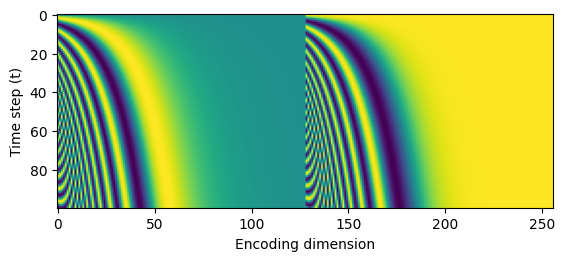

In [12]:
plt.imshow(pos_encs.cpu().numpy())
plt.xlabel("Encoding dimension")
plt.ylabel("Time step (t)")
plt.show()

## Defining the Attention U-Net

In [13]:
import deeplay as dl

unet = dl.AttentionUNet(
    in_channels=1, channels=[32, 64, 128], base_channels=[256, 256],
    channel_attention=[True, True, True], out_channels=1,
    position_embedding_dim=pos_enc_dim,
).build().to(device)

## Training the Diffusion Model

Define the data loader ...

In [14]:
loader = dl.DataLoader(dataset=trainset, batch_size=128, shuffle=True)

... define the loss function ...

In [15]:
criterion = torch.nn.MSELoss()

... define the optimizer ...

In [16]:
optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-4)

...  instantiate the diffusion class for training ...

In [17]:
diffusion = Diffusion(steps=1000, beta_start=1e-4, beta_end=0.02, img_size=28)

...implement a function to prepare the data ...

In [18]:
def prepare_data(image, steps=1000, device=device):
    """Prepare data."""
    batch_size = image.shape[0]
    t = torch.randint(low=0, high=steps, size=(batch_size,)).to(device)
    image = image.to(device)
    x_t, noise = diffusion.forward_diffusion(image, t)
    t_pos_enc = positional_encoding(t.unsqueeze(1), pos_enc_dim)
    return x_t.to(device), t_pos_enc.to(device), noise.to(device)

... and implement the training cycle.


Epoch 1/20
__________
Batch 1/469: Train loss: 0.9276
Batch 101/469: Train loss: 0.1688
Batch 201/469: Train loss: 0.0823
Batch 301/469: Train loss: 0.0699
Batch 401/469: Train loss: 0.0717
----------
Epoch 1/20 : Train loss: 0.1158, Time taken: 0:11:12.802439


U-Net inference: 100%|██████████| 1000/1000 [00:33<00:00, 30.19it/s]


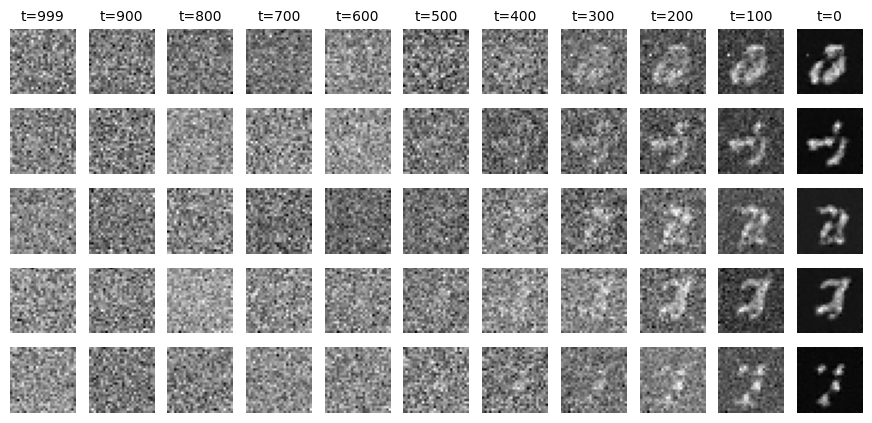


Epoch 2/20
__________
Batch 1/469: Train loss: 0.0558
Batch 101/469: Train loss: 0.0473
Batch 201/469: Train loss: 0.0433
Batch 301/469: Train loss: 0.0441
Batch 401/469: Train loss: 0.0385
----------
Epoch 2/20 : Train loss: 0.0465, Time taken: 0:11:13.132025


U-Net inference: 100%|██████████| 1000/1000 [00:44<00:00, 22.28it/s]


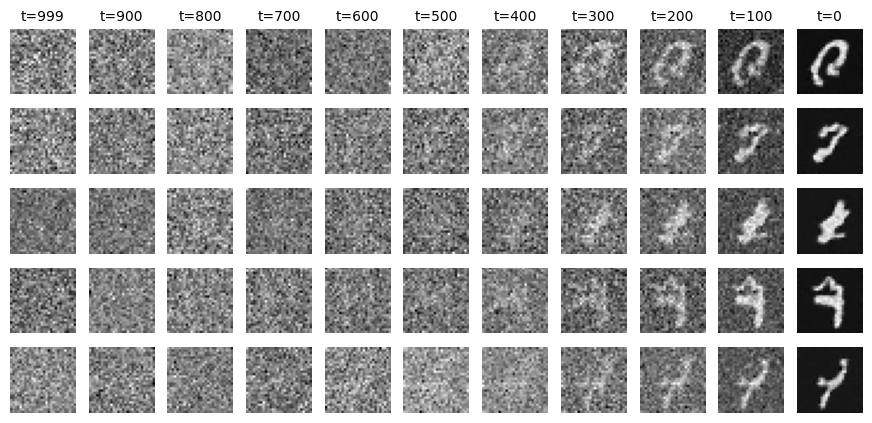


Epoch 3/20
__________
Batch 1/469: Train loss: 0.0470
Batch 101/469: Train loss: 0.0400
Batch 201/469: Train loss: 0.0315
Batch 301/469: Train loss: 0.0331
Batch 401/469: Train loss: 0.0402
----------
Epoch 3/20 : Train loss: 0.0387, Time taken: 0:11:26.319325


U-Net inference: 100%|██████████| 1000/1000 [00:39<00:00, 25.13it/s]


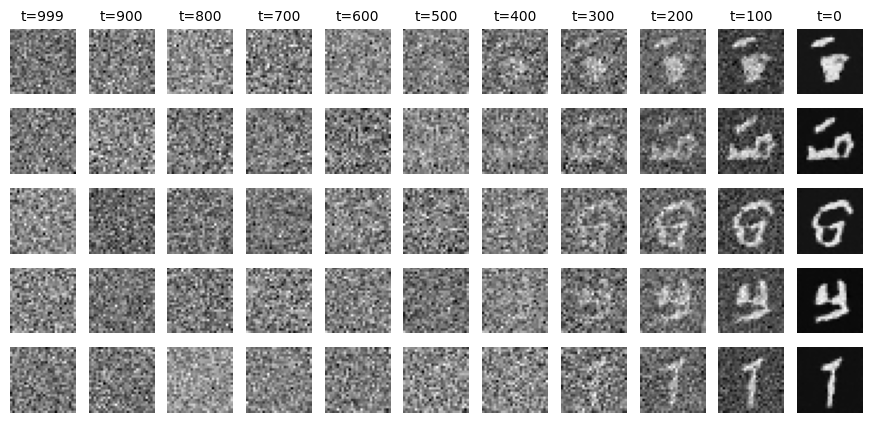


Epoch 4/20
__________
Batch 1/469: Train loss: 0.0383
Batch 101/469: Train loss: 0.0440
Batch 201/469: Train loss: 0.0395
Batch 301/469: Train loss: 0.0348
Batch 401/469: Train loss: 0.0295
----------
Epoch 4/20 : Train loss: 0.0356, Time taken: 0:11:08.304682


U-Net inference: 100%|██████████| 1000/1000 [00:36<00:00, 27.27it/s]


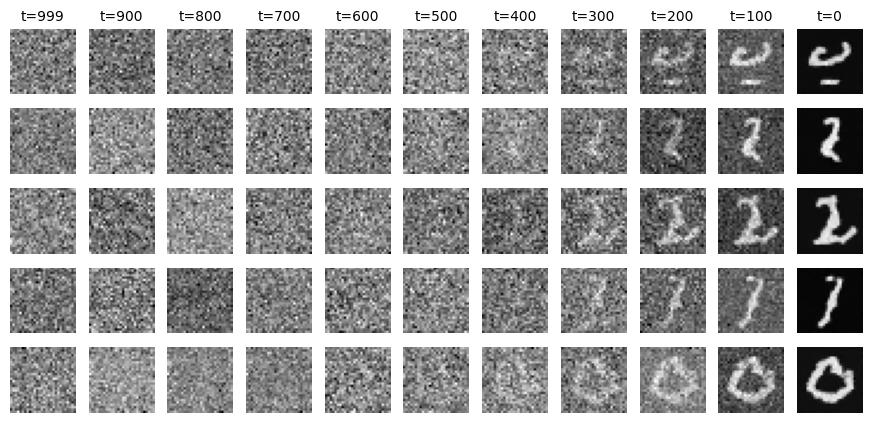


Epoch 5/20
__________
Batch 1/469: Train loss: 0.0373
Batch 101/469: Train loss: 0.0274
Batch 201/469: Train loss: 0.0343
Batch 301/469: Train loss: 0.0282
Batch 401/469: Train loss: 0.0314
----------
Epoch 5/20 : Train loss: 0.0326, Time taken: 0:10:56.026003


U-Net inference: 100%|██████████| 1000/1000 [00:36<00:00, 27.50it/s]


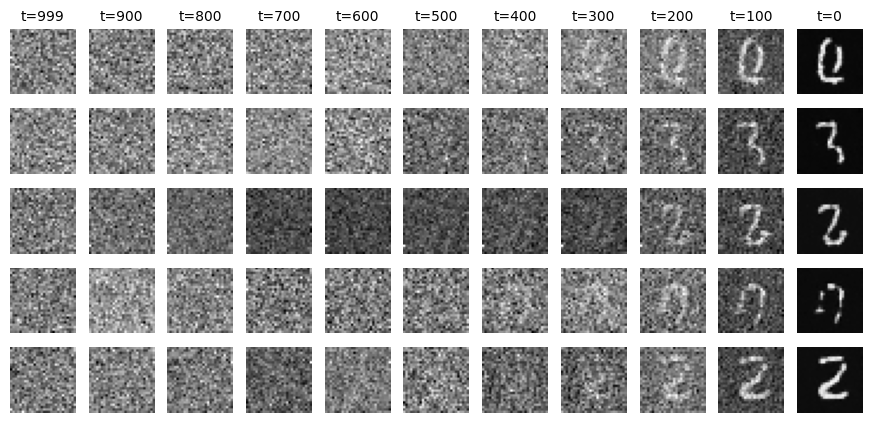


Epoch 6/20
__________
Batch 1/469: Train loss: 0.0327
Batch 101/469: Train loss: 0.0233
Batch 201/469: Train loss: 0.0309
Batch 301/469: Train loss: 0.0225
Batch 401/469: Train loss: 0.0294
----------
Epoch 6/20 : Train loss: 0.0313, Time taken: 0:10:57.486455


U-Net inference: 100%|██████████| 1000/1000 [00:42<00:00, 23.80it/s]


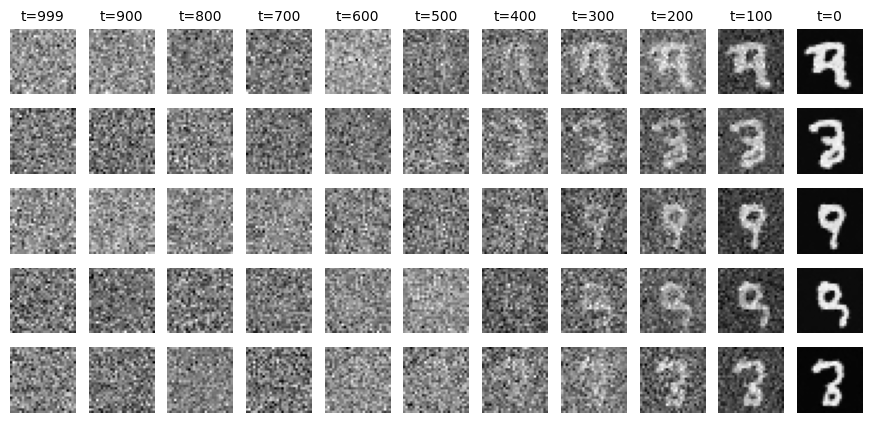


Epoch 7/20
__________
Batch 1/469: Train loss: 0.0307
Batch 101/469: Train loss: 0.0289
Batch 201/469: Train loss: 0.0286
Batch 301/469: Train loss: 0.0319
Batch 401/469: Train loss: 0.0250
----------
Epoch 7/20 : Train loss: 0.0307, Time taken: 0:10:59.676724


U-Net inference: 100%|██████████| 1000/1000 [00:42<00:00, 23.74it/s]


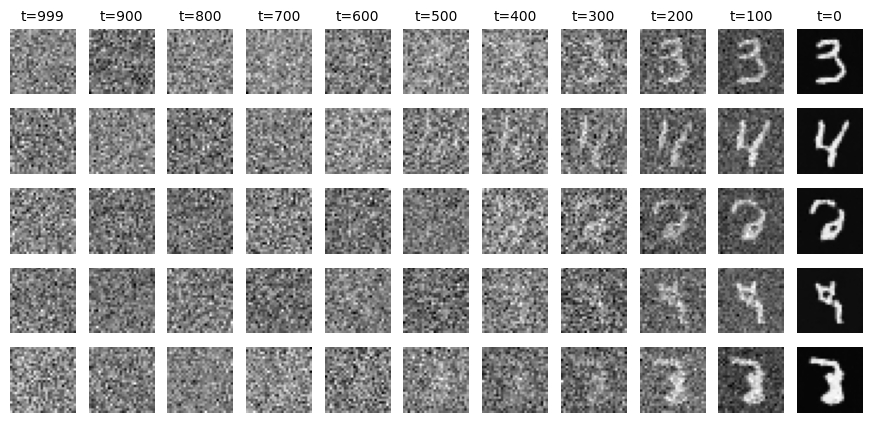


Epoch 8/20
__________
Batch 1/469: Train loss: 0.0311
Batch 101/469: Train loss: 0.0324
Batch 201/469: Train loss: 0.0309
Batch 301/469: Train loss: 0.0270
Batch 401/469: Train loss: 0.0288
----------
Epoch 8/20 : Train loss: 0.0287, Time taken: 0:11:11.634894


U-Net inference: 100%|██████████| 1000/1000 [00:36<00:00, 27.16it/s]


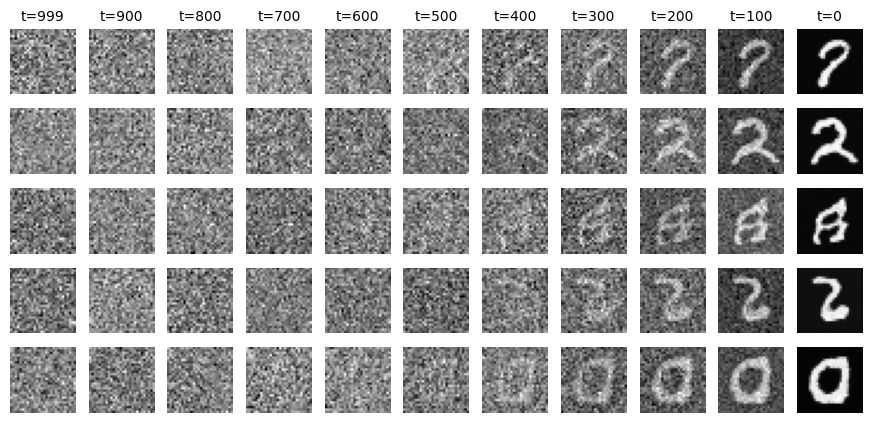


Epoch 9/20
__________
Batch 1/469: Train loss: 0.0315
Batch 101/469: Train loss: 0.0267
Batch 201/469: Train loss: 0.0258
Batch 301/469: Train loss: 0.0209
Batch 401/469: Train loss: 0.0280
----------
Epoch 9/20 : Train loss: 0.0280, Time taken: 0:11:11.150139


U-Net inference: 100%|██████████| 1000/1000 [00:40<00:00, 24.81it/s]


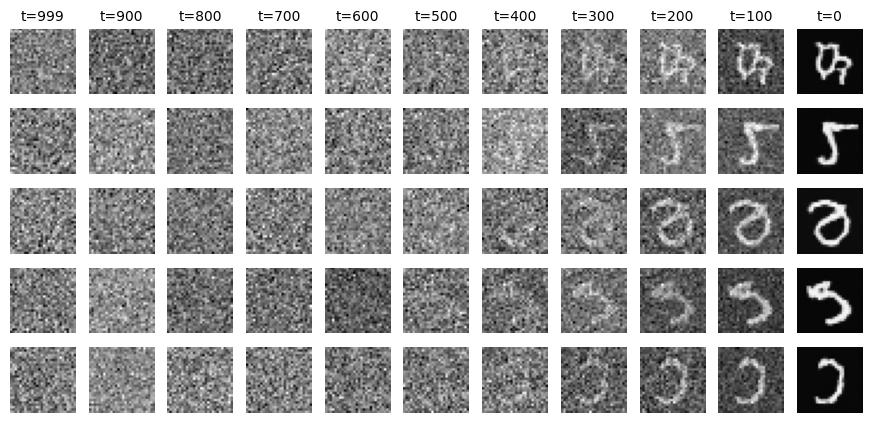


Epoch 10/20
__________
Batch 1/469: Train loss: 0.0251
Batch 101/469: Train loss: 0.0252
Batch 201/469: Train loss: 0.0293
Batch 301/469: Train loss: 0.0358
Batch 401/469: Train loss: 0.0272
----------
Epoch 10/20 : Train loss: 0.0275, Time taken: 0:10:59.215883


U-Net inference: 100%|██████████| 1000/1000 [00:40<00:00, 24.57it/s]


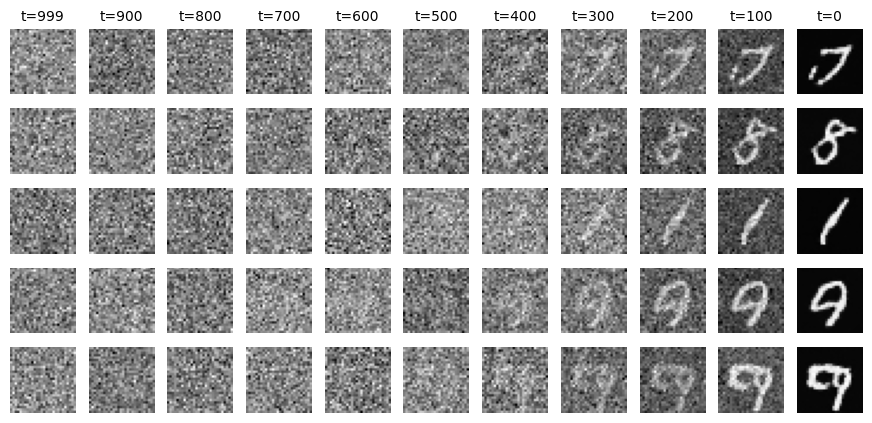


Epoch 11/20
__________
Batch 1/469: Train loss: 0.0317
Batch 101/469: Train loss: 0.0263
Batch 201/469: Train loss: 0.0229
Batch 301/469: Train loss: 0.0251
Batch 401/469: Train loss: 0.0251
----------
Epoch 11/20 : Train loss: 0.0269, Time taken: 0:10:58.374804


U-Net inference: 100%|██████████| 1000/1000 [00:34<00:00, 28.77it/s]


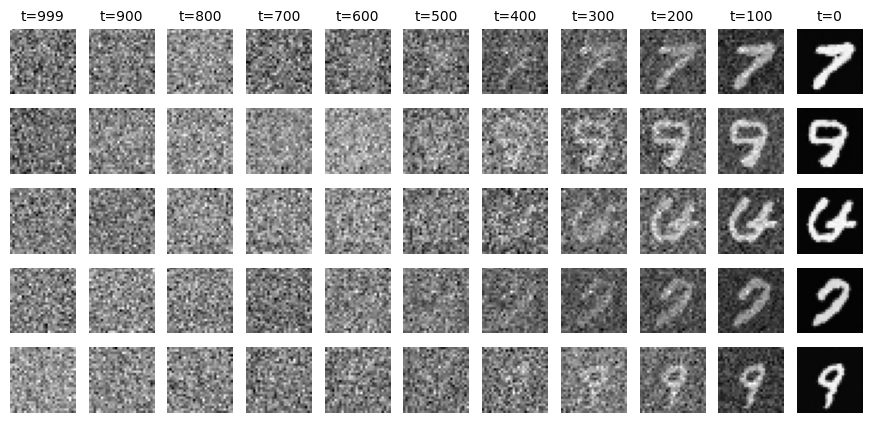


Epoch 12/20
__________
Batch 1/469: Train loss: 0.0299
Batch 101/469: Train loss: 0.0277
Batch 201/469: Train loss: 0.0277
Batch 301/469: Train loss: 0.0314
Batch 401/469: Train loss: 0.0324
----------
Epoch 12/20 : Train loss: 0.0265, Time taken: 0:11:00.717561


U-Net inference: 100%|██████████| 1000/1000 [00:43<00:00, 23.07it/s]


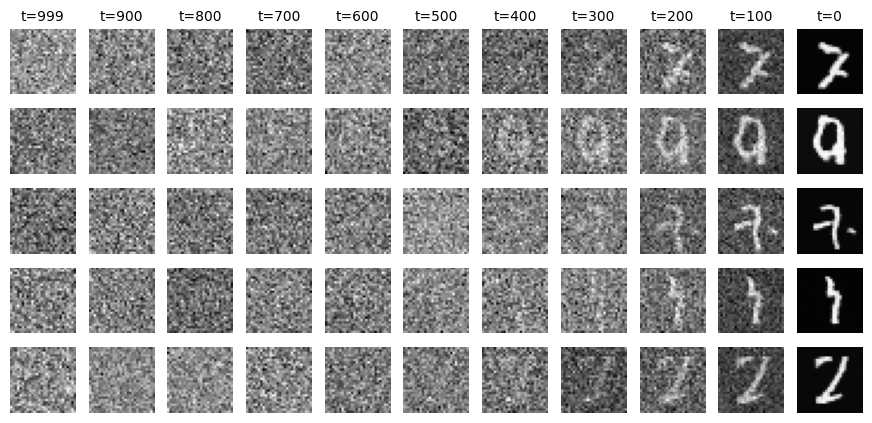


Epoch 13/20
__________
Batch 1/469: Train loss: 0.0290
Batch 101/469: Train loss: 0.0235
Batch 201/469: Train loss: 0.0264
Batch 301/469: Train loss: 0.0229
Batch 401/469: Train loss: 0.0228
----------
Epoch 13/20 : Train loss: 0.0262, Time taken: 0:10:58.887154


U-Net inference: 100%|██████████| 1000/1000 [00:43<00:00, 23.06it/s]


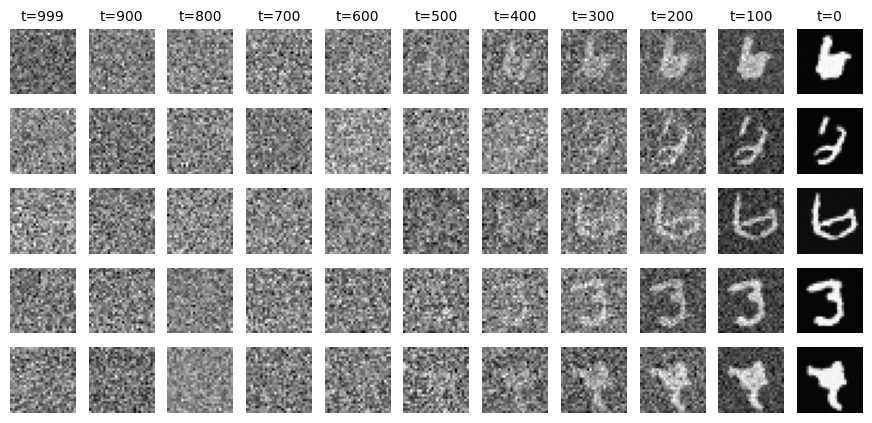


Epoch 14/20
__________
Batch 1/469: Train loss: 0.0238
Batch 101/469: Train loss: 0.0275
Batch 201/469: Train loss: 0.0225
Batch 301/469: Train loss: 0.0245
Batch 401/469: Train loss: 0.0308
----------
Epoch 14/20 : Train loss: 0.0258, Time taken: 0:10:57.719275


U-Net inference: 100%|██████████| 1000/1000 [00:43<00:00, 23.07it/s]


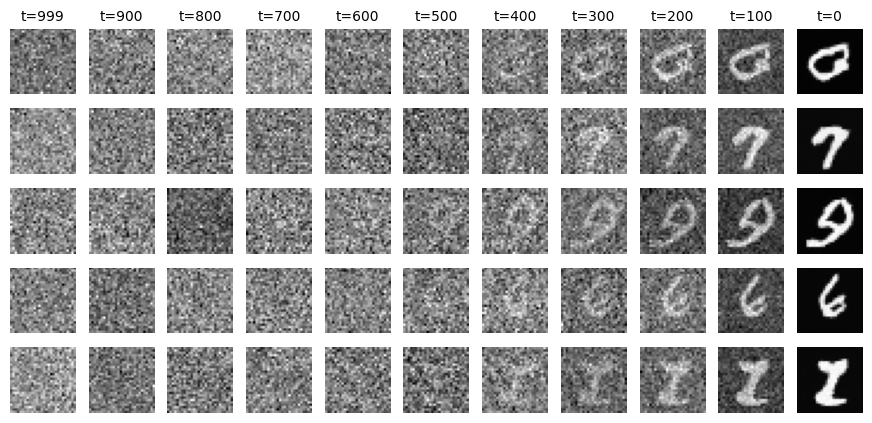


Epoch 15/20
__________
Batch 1/469: Train loss: 0.0236
Batch 101/469: Train loss: 0.0249
Batch 201/469: Train loss: 0.0293
Batch 301/469: Train loss: 0.0244
Batch 401/469: Train loss: 0.0253
----------
Epoch 15/20 : Train loss: 0.0257, Time taken: 0:10:58.534405


U-Net inference: 100%|██████████| 1000/1000 [00:40<00:00, 24.58it/s]


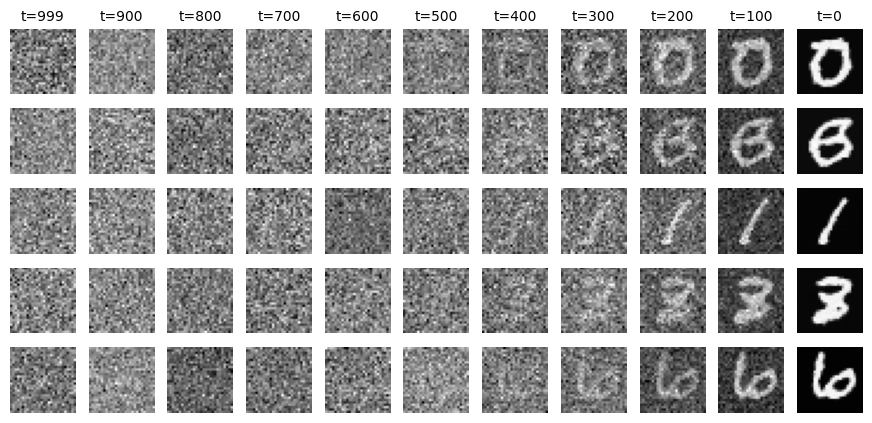


Epoch 16/20
__________
Batch 1/469: Train loss: 0.0282
Batch 101/469: Train loss: 0.0289
Batch 201/469: Train loss: 0.0224
Batch 301/469: Train loss: 0.0205
Batch 401/469: Train loss: 0.0232
----------
Epoch 16/20 : Train loss: 0.0253, Time taken: 0:10:59.883779


U-Net inference: 100%|██████████| 1000/1000 [00:38<00:00, 25.73it/s]


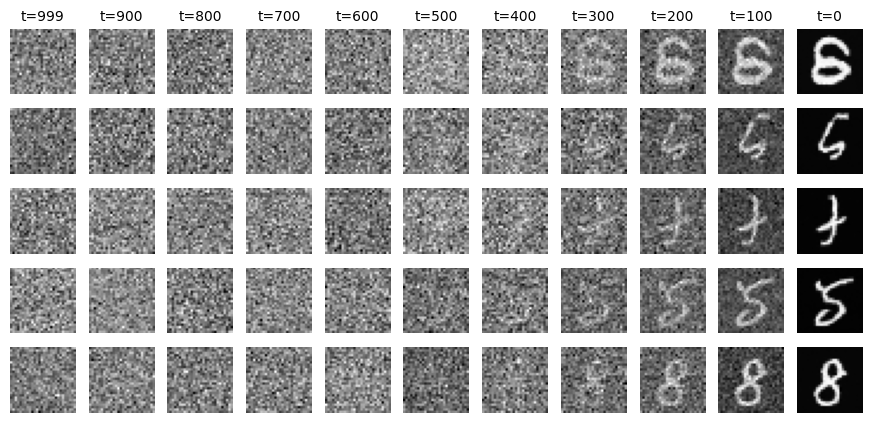


Epoch 17/20
__________
Batch 1/469: Train loss: 0.0275
Batch 101/469: Train loss: 0.0249
Batch 201/469: Train loss: 0.0240
Batch 301/469: Train loss: 0.0248
Batch 401/469: Train loss: 0.0237
----------
Epoch 17/20 : Train loss: 0.0249, Time taken: 0:10:59.918401


U-Net inference: 100%|██████████| 1000/1000 [00:40<00:00, 24.99it/s]


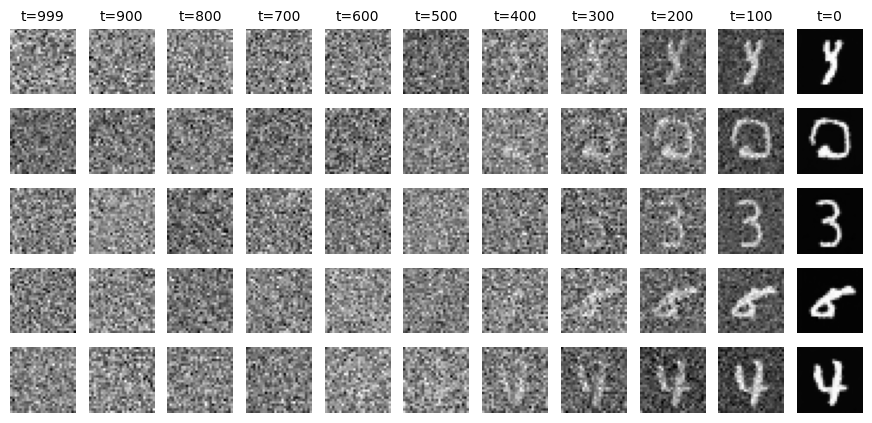


Epoch 18/20
__________
Batch 1/469: Train loss: 0.0247
Batch 101/469: Train loss: 0.0292
Batch 201/469: Train loss: 0.0245
Batch 301/469: Train loss: 0.0242
Batch 401/469: Train loss: 0.0277
----------
Epoch 18/20 : Train loss: 0.0247, Time taken: 0:10:58.429790


U-Net inference: 100%|██████████| 1000/1000 [00:43<00:00, 23.05it/s]


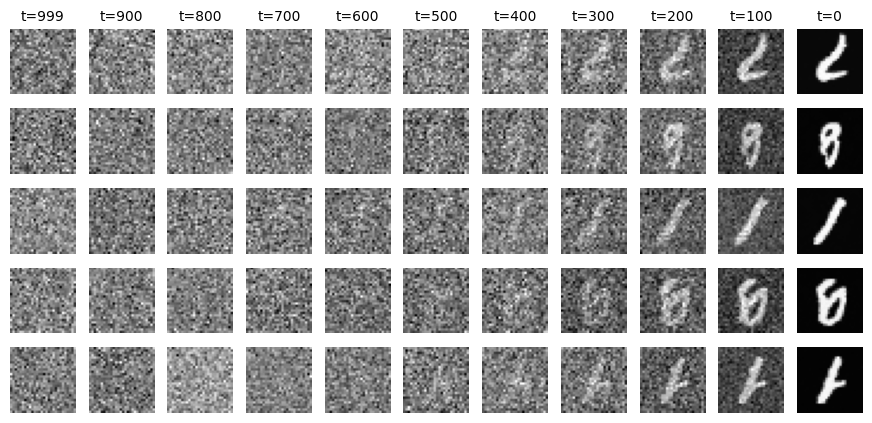


Epoch 19/20
__________
Batch 1/469: Train loss: 0.0218
Batch 101/469: Train loss: 0.0172
Batch 201/469: Train loss: 0.0268
Batch 301/469: Train loss: 0.0247
Batch 401/469: Train loss: 0.0278
----------
Epoch 19/20 : Train loss: 0.0245, Time taken: 0:11:01.905739


U-Net inference: 100%|██████████| 1000/1000 [00:37<00:00, 26.95it/s]


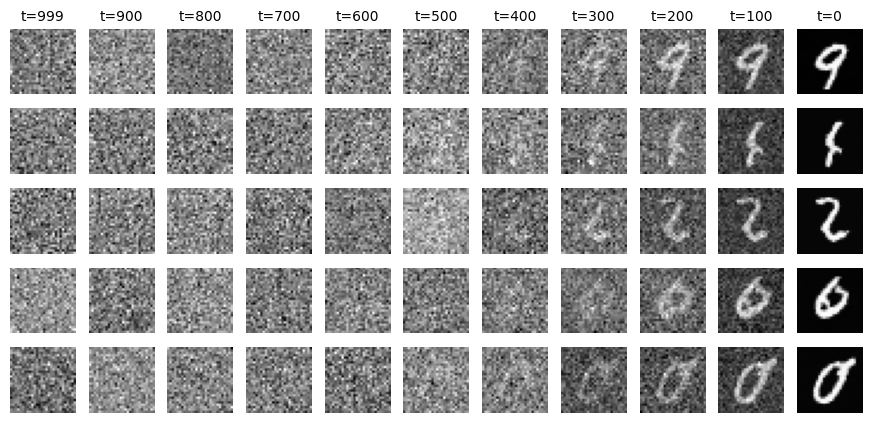


Epoch 20/20
__________
Batch 1/469: Train loss: 0.0235
Batch 101/469: Train loss: 0.0230
Batch 201/469: Train loss: 0.0295
Batch 301/469: Train loss: 0.0222
Batch 401/469: Train loss: 0.0211
----------
Epoch 20/20 : Train loss: 0.0245, Time taken: 0:11:02.713245


U-Net inference: 100%|██████████| 1000/1000 [00:37<00:00, 26.98it/s]


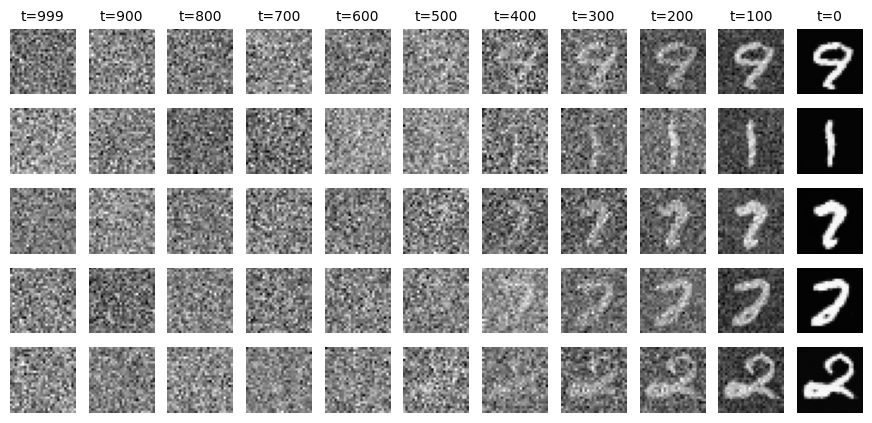

In [ ]:
import time
from datetime import timedelta

epochs = 20

n_images, steps = 5, [999, 900, 800, 700, 600, 500, 400, 300, 200, 100, 0]
train_loss = []
for epoch in range(epochs):
    unet.train()

    start_time = time.time()
    print("\n" + f"Epoch {epoch + 1}/{epochs}" + "\n" + "_" * 10)

    running_loss = 0.0
    for batch_idx, (images, class_labels) in enumerate(loader, start=0):
        x_t, t_pos_enc, noise = prepare_data(images)

        outputs = unet(x=x_t, t=t_pos_enc)

        optimizer.zero_grad()
        loss = criterion(outputs, noise)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx + 1}/{len(loader)}: "
                  f"Train loss: {loss.item():.4f}")
        running_loss += loss.item()

    train_loss.append(running_loss / len(loader))
    end_time = time.time()

    print("-" * 10 + "\n" + f"Epoch {epoch + 1}/{epochs} : "
          f"Train loss: {train_loss[-1]:.4f}, "
          f"Time taken: {timedelta(seconds=end_time - start_time)}")

    unet.eval()
    generated_images = diffusion.reverse_diffusion(
        model=unet, n_images=n_images, n_channels=1, pos_enc_dim=pos_enc_dim,
        pos_enc_func=positional_encoding, save_time_steps=steps,
    )

    fig = plt.figure(figsize=(len(steps), n_images))
    for idx in range(n_images):
        image_reverse_diff_traj = generated_images[idx]
        for j in range(len(steps)):
            plt.subplot(n_images, len(steps), idx * len(steps) + j + 1)
            plt.imshow(image_reverse_diff_traj[j]
                       .permute(1, 2, 0).cpu().numpy(), cmap="gray")
            plt.axis("off")
            if idx == 0: plt.title(f"t={steps[j]}", fontsize=10)
    plt.show()
    plt.close()

## Sampling Images From Fixed Noise

U-Net inference: 100%|██████████| 1000/1000 [00:09<00:00, 100.46it/s]


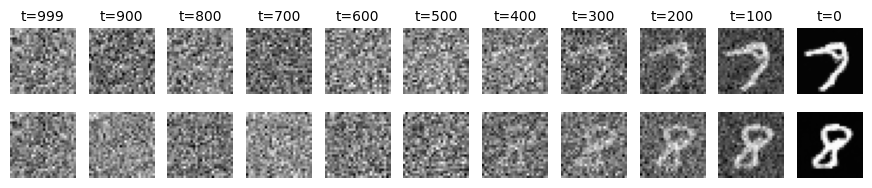

In [20]:
unet.eval()

fix_noise = torch.randn((1, 1, 28, 28))
n_images_fix_noise = 2

fig = plt.figure(figsize=(len(steps), n_images_fix_noise))
for idx in range(n_images_fix_noise):
    generated_images = diffusion.reverse_diffusion(
        model=unet, n_images=1, n_channels=1, fix_noise=fix_noise,
        pos_enc_dim=pos_enc_dim, pos_enc_func=positional_encoding,
        save_time_steps=steps,
    )

    image_reverse_diff_traj = generated_images[0]
    for j in range(len(image_reverse_diff_traj)):
        plt.subplot(n_images_fix_noise, len(steps), idx * len(steps) + j + 1)
        plt.imshow(image_reverse_diff_traj[j]
                   .permute(1, 2, 0).cpu().numpy(), cmap="gray")
        plt.axis("off")
        if idx == 0: plt.title(f"t={steps[j]}", fontsize=10)